Todo:
- load two models
    - a yolo model (for detecting the cars)
    - our custom license plate detection model (for license plates_
- get an image
- detect cars in it (select the biggest car)
- crop the image to that car
- detect the license plate in the cropped image
- crop the image to the license plate
- image processing on it (threshold, erode, dilate, blur, ...)
- use contours/connectedComponents to find the different digits
- extract each digit as a seperate image and store it in a list [char1_img, char2_img, ...]
- feed this array to the digit classifier and get the results back
- vizualize on the original image(bounding box of car, bounding box of plate, text of plate on top of it)
- return the license plate text
- turn into .py scripts
- create a gradio app
- upload to huggingface

In [2]:
# !pip install -qU ultralytics

In [3]:
# Download the trained models and some images
# !wget https://huggingface.co/Gholamreza/yolo11_license_plate_detection/resolve/main/detect/yolo11n_anpr/weights/best.pt -O yolo11_anpr_ghd.pt
# !wget https://huggingface.co/Gholamreza/yolo11_license_plate_detection/resolve/main/car_a.jpg
# !wget https://huggingface.co/Gholamreza/yolo11_license_plate_detection/resolve/main/car_b.jpg
# !wget https://huggingface.co/Gholamreza/yolo11_license_plate_detection/resolve/main/car_c.jpg
# !wget https://huggingface.co/Gholamreza/yolo11_license_plate_detection/resolve/main/car_d.jpg

In [4]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [5]:
def filter_boxes_by_class(boxes, cls_id):
    """
    Filters the bounding boxes based on the specified class ID e.g. cls_id=2 for cars.

    Args:
        boxes: A YOLO boxes object.
        cls_id: The class ID to filter the boxes by.

    Returns:
        A list of xyxy tensors corresponding to the specified class ID.
    """
    mask = boxes.cls == cls_id
    filtered_xyxy = boxes.xyxy[mask]
    return filtered_xyxy.cpu().tolist()


## Detect the car(s)

Detect the biggest car in the image using a pretrained raw yolo11n model

In [6]:
# raw yolo object detection model that can detect cars
image_name = "car_a.jpg"
yolo_model = YOLO("yolo11n.pt")
car_results = yolo_model(image_name)

# filter the results to get only the car bboxes
car_boxes = filter_boxes_by_class(car_results[0].boxes, 2)

# sort the results based on area
sorted_car_boxes = sorted(car_boxes, key=lambda x: abs(x[2] - x[0]) * abs(x[3] - x[1]), reverse=True)


image 1/1 g:\pgming\yolo11-license-plate-recognition\car_a.jpg: 640x480 2 persons, 5 cars, 185.5ms
Speed: 0.0ms preprocess, 185.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


In [7]:
img = cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# draw the biggest car's bbox
car_bbox = sorted_car_boxes[0]
img_drawn = cv2.rectangle(img.copy(), (int(car_bbox[0]), int(car_bbox[1])), (int(car_bbox[2]), int(car_bbox[3])), (255, 255, 0), 6)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_drawn)
plt.title("Detect the Car")
plt.show()

## Crop the car

Crop the image to get a car only image

In [8]:
# crop the car from the image
cropped_car_image = img[int(car_bbox[1]):int(car_bbox[3]), int(car_bbox[0]):int(car_bbox[2])]

# display the cropped image
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cropped_car_image)
plt.title("Cropped Car Image")
plt.show()

## Detect the license plate

Detect the license plate from the cropped car image using our fine-tuned license plate detection model

In [9]:
# our custom license plate detection model that is based on yolo11n
model = YOLO("yolo11_anpr_ghd.pt")
results = model(cropped_car_image)
license_box = results[0].boxes[0].xyxy[0].cpu().numpy()


0: 576x640 1 LicensePlate, 193.7ms
Speed: 0.0ms preprocess, 193.7ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


In [10]:
img_drawn = cv2.rectangle(cropped_car_image.copy(), (int(license_box[0]), int(license_box[1])), (int(license_box[2]), int(license_box[3])), (255, 255, 0), 3)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_drawn)
plt.title("Detect the License Plate")
plt.show()

## Crop the license plate

Crop the license plate to get a license plate only image

In [11]:
# Crop the image based on the bounding box
cropped_license_image = cropped_car_image[int(license_box[1]):int(license_box[3]), int(license_box[0]):int(license_box[2])]

# Display the cropped image
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cropped_license_image)
plt.title("Cropped License Plate Image")
plt.show()

## Align the license plate

Align the license plate using houghlines

In [12]:
import numpy as np
def straighten_skewed_rectangle(img):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    if len(lines) < 2:
        print("Not enough lines found. returning the original image")
        return img

    # Find the longest lines
    longest_lines = sorted(lines, key=lambda l: np.linalg.norm((l[0][2]-l[0][0], l[0][3]-l[0][1])), reverse=True)[:2]

    # Draw the lines on the image
    # drawn_img = img.copy()
    # for line in longest_lines:
    #     x1, y1, x2, y2 = line[0]
    #     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Calculate angles of the longest lines
    angles = []
    for line in longest_lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)

    # Average the angles to get a more stable rotation estimate
    average_angle = np.mean(angles)

    # Rotate the image by the negative of the average angle
    height, width = img.shape[:2]
    center = (width // 2, height // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, average_angle, 1.0)

    # Calculate the size of the new image to include padding
    cos_theta = abs(M[0, 0])
    sin_theta = abs(M[0, 1])
    new_width = int((height * sin_theta) + (width * cos_theta))
    new_height = int((height * cos_theta) + (width * sin_theta))

    # Adjust the rotation matrix to account for translation
    M[0, 2] += (new_width / 2) - center[0]
    M[1, 2] += (new_height / 2) - center[1]

    # Perform the rotation and padding
    rotated_img = cv2.warpAffine(img, M, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return rotated_img

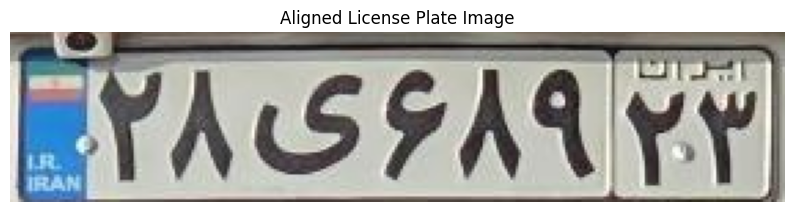

In [13]:
straight_license_plate_img = straighten_skewed_rectangle(cropped_license_image)
# straight_license_plate_img = cropped_license_image
# Display the aligned license plate
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(straight_license_plate_img)
plt.title("Aligned License Plate Image")
plt.show()

In [14]:
# thresholding
img_gray = cv2.cvtColor(straight_license_plate_img, cv2.COLOR_RGB2GRAY)
# ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
ret, thresh = cv2.threshold(img_gray, 90, 255, cv2.THRESH_BINARY_INV)
# display
plt.imshow(thresh, cmap='gray')
plt.show()


## Digit Segmentation

Extract the digits using image processing techniques

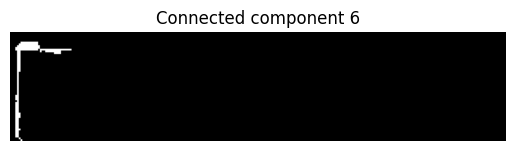

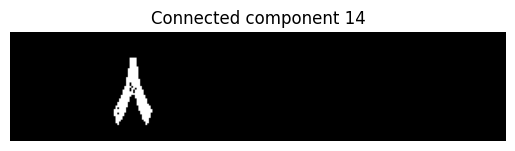

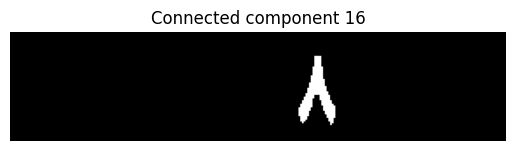

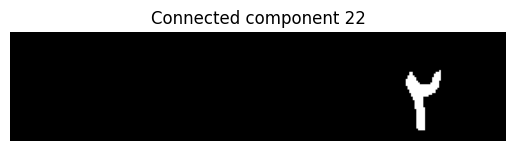

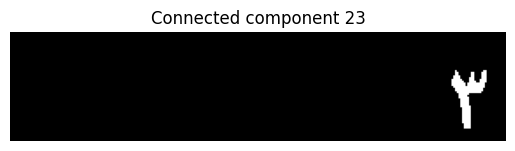

In [15]:
# findcontours
img = thresh.copy()

# connected components
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)
digits_imgs = []
digits_x = []
for i in range(0, numLabels):
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]
	(cX, cY) = centroids[i]

	# TODO: change these area thresholds
	img_area = img.shape[0] * img.shape[1]
	if area > 0.002* img_area and area < 0.05 * img_area:
		# the bbox should be a vertical rectangle
		if w <= h:
			output = straight_license_plate_img.copy()
			cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
			cv2.circle(output, (int(cX), int(cY)), 1, (0, 0, 255), -1)
			componentMask = (labels == i).astype("uint8") * 255

			digits_imgs.append(componentMask[y:y + h, x:x + w])
			digits_x.append(x)

			plt.title(f"Connected component {i+1}")
			plt.axis("off")
			plt.imshow(componentMask, cmap="gray")
			plt.show()

In [16]:
digits_x
indices = np.argsort(digits_x).tolist()
print(digits_x)
print(indices)


[3, 33, 59, 137, 164, 191, 225, 251]
[0, 1, 2, 3, 4, 5, 6, 7]


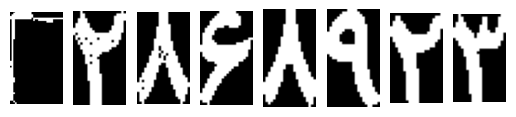

In [17]:
# sort the digits based on x
indices = np.argsort(digits_x).tolist()

# plt.figure(figsize=(2, 2))
counter = 1
sorted_digit_imgs = []
for i in indices:
    plt.subplot(1, 8, counter)
    plt.axis('off')
    plt.imshow(digits_imgs[i], cmap='gray')
    sorted_digit_imgs.append(digits_imgs[i])
    counter += 1
plt.show()

In [18]:
resized_imgs = []
for i in range(len(sorted_digit_imgs)):
    # resize to 28x28
    resized_img = np.pad(sorted_digit_imgs[i], (2,2), 'constant', constant_values=0)
    resized_img = cv2.resize(resized_img, (28, 28), interpolation=cv2.INTER_AREA)
    # add a 2 pixel padding
    resized_imgs.append(resized_img)

    # from 0-255 to 0-1
    resized_imgs[i] = resized_imgs[i].astype(float) / 255

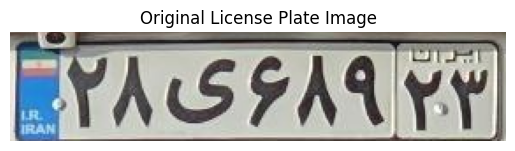

In [19]:
plt.title('Original License Plate Image')
plt.imshow(cropped_license_image)
plt.axis('off')
plt.show()

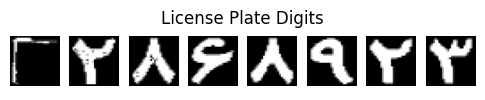

In [20]:
plt.figure(figsize=(6,1/8*6))
plt.title("License Plate Digits")
plt.axis('off')
for i in range(len(resized_imgs)):
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(resized_imgs[i], cmap='gray')
plt.show()

## Refactor into a function

In [21]:
# enable autoreload
%load_ext autoreload

# auto reload
%autoreload 2

In [22]:
import license_plate_extractor
import importlib
importlib.reload(license_plate_extractor)

from license_plate_extractor import extract_digits
from license_plate_extractor import show_resized_images


image 1/1 g:\pgming\yolo11-license-plate-recognition\car_a.jpg: 640x480 2 persons, 5 cars, 153.6ms
Speed: 0.0ms preprocess, 153.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 576x640 1 LicensePlate, 166.9ms
Speed: 7.5ms preprocess, 166.9ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


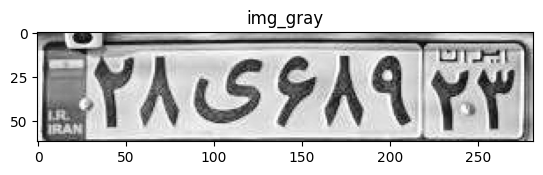

8/8 digits detected


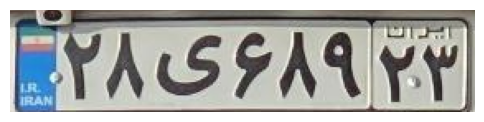

In [23]:
digits, original = extract_digits(
    "car_a.jpg",
    min_area=0.013,
    max_area=0.05,
    debug=False,
    show=False,
    prefix="car_a")

show_resized_images(digits, original)


image 1/1 g:\pgming\yolo11-license-plate-recognition\car_b.jpg: 640x512 9 cars, 192.6ms
Speed: 0.0ms preprocess, 192.6ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 512)

0: 576x640 1 LicensePlate, 156.3ms
Speed: 0.0ms preprocess, 156.3ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)
Not enough lines found. returning the original image


8/8 digits detected


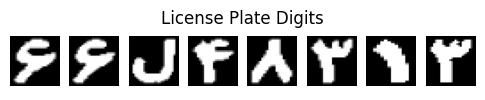

In [24]:
digits, original = extract_digits(
    "car_b.jpg",
    min_area=0.012,
    max_area=0.05,
    debug=False,
    show=False,
    prefix="car_b")

show_resized_images(digits, original)


image 1/1 g:\pgming\yolo11-license-plate-recognition\car_c.jpg: 512x640 3 cars, 1 stop sign, 194.6ms
Speed: 10.0ms preprocess, 194.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 LicensePlate, 146.7ms
Speed: 0.0ms preprocess, 146.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


8/8 digits detected


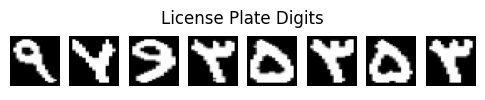

In [49]:
digits, original = extract_digits(
    "car_c.jpg",
    min_area=0.002,
    max_area=0.05,
    debug=False,
    show=False,
    prefix="car_c")

show_resized_images(digits, original)


image 1/1 g:\pgming\yolo11-license-plate-recognition\car_d.jpg: 544x640 2 cars, 1 truck, 163.1ms
Speed: 7.0ms preprocess, 163.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 2 LicensePlates, 135.8ms
Speed: 7.4ms preprocess, 135.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
Not enough lines found. returning the original image


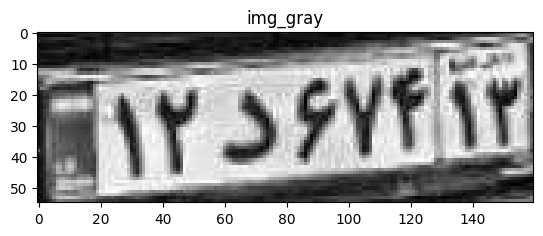

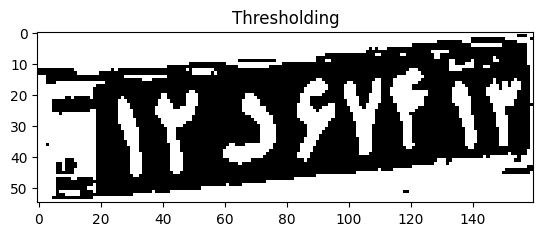

8/8 digits detected


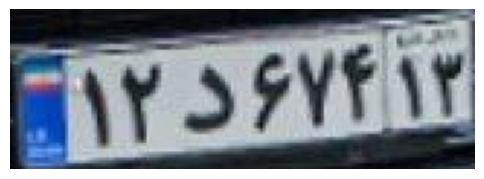

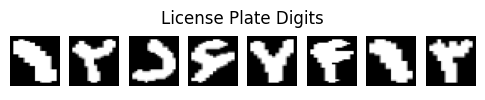

In [43]:
digits, original = extract_digits(
    "car_d.jpg",
    min_area=0.003,
    max_area=0.04,
    debug=False,
    show=False,
    prefix="car_d")

show_resized_images(digits, original)

## Digit Classification

classify the extracted digits using our trained classifer

In [58]:
from image_classifier import ImageClassifier

weights_path = 'persian_digit_classifier.pt'
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Alef', 'BE', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'Vav', 'y', 'z', 'za', 'zad', 'zal', 'zh']

classifier = ImageClassifier(weights_path, class_names)

# Predict the class
predicted_digits = []
for i in range(len(digits)):
    predicted_class = classifier.predict(1.0 - digits[i])
    predicted_digits.append(predicted_class)

print(" ".join(predicted_digits))

Model loaded successfully.
9 7 Vav 3 5 3 5 3


In [40]:
np.save('digits.npy', digits)